<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/17.00.Aula-Construindo_Cenarios_e_Pop_Multi_350_residencial.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- Modelos individuais - reformulação da implementação](16.00.Aula-Modelos_individuais_reformulacao.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [O cenário de múltiplos do Pop350: redes sociais ->](18.00.Aula-Construindo_Cenarios_e_Pop_Multi_350_social.ipynb)

---


# Construção de cenários: definindo as idades

- O objetivo, aqui, é definir as idades de cada indivíduo da população.

- Isso será feito após a alocação dos indivíduos em residências.

- Como exemplo, vamos usar a rede de residências de uma fração da população do Rio de Janeiro.

In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np
from scipy.stats import zipf

import networkx as nx

from numba import jit, njit, prange
from numba.typed import List
import threading # for multi-threading with numba.jit

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import episiming

In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 07/Jun/2020


## Distribuição espacial da população da cidade do Rio de Janeiro

### Carregando os dados

Os dados populacionais por quilômetro quadrado da cidade do Rio de Janeiro foram obtidos pelo [Landscan](https://landscan.ornl.gov).

Como feito anteriormente, após carregarmos os dados, zeramos os valores das células com -1, que indicam falta de informação.

In [5]:
landscan_rio = np.maximum(np.load('../input/dados_rio/landscan_rio.npy').astype(int), 0)

### Reduzindo a população para testes

Na montagem do cenário, com o objetivo de realizar testes mais rápidos, com populações menores, dividimos a população de cada bloco por um determinado fator.

Essa divisão nos dá números em ponto flutuante, que então truncamos para a sua parte inteira.

In [6]:
pop_por_bloco = (landscan_rio/100).astype(int)
num_pop = pop_por_bloco.sum()
print(f'População: {num_pop}')

População: 67973


### Visualização da distribuição populacional em escala logarítmica

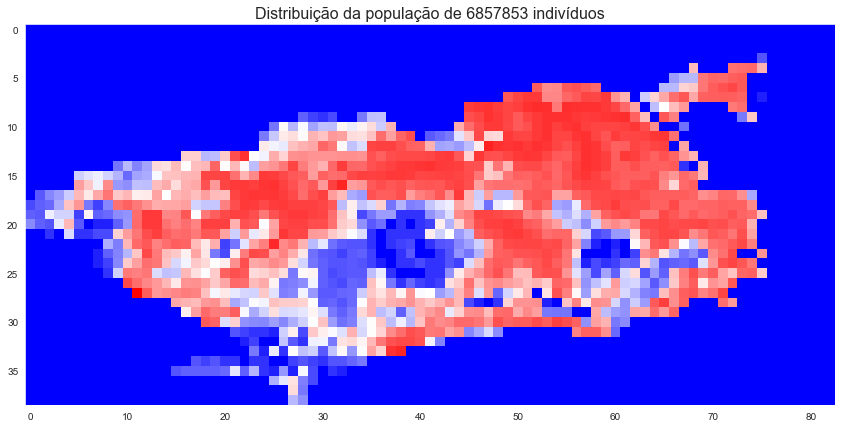

In [7]:
plt.figure(figsize=(15,7))
plt.imshow(np.log(1 + landscan_rio), cmap='bwr', interpolation='nearest')
plt.grid(False)
plt.title(f'Distribuição da população de {int(landscan_rio.sum())} indivíduos', fontsize=16)
plt.show()

### Censo residencial

A distribuição da população em residências é feita segundo um censo com a porcentagem de residências por número de residentes:

In [8]:
censo_residencial = np.array([.21, .26, .20, .17, .08, .04, .02, 0.02])

### Distribuindo e alocando os indivíduos e as suas residências

In [9]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_bloco, censo_residencial)

CPU times: user 823 ms, sys: 15.4 ms, total: 838 ms
Wall time: 850 ms


### Distribuição por tamanho de residência

In [10]:
num_tam_res = len(censo_residencial)
distrib_tam_por_res = np.array([len(res_individuos[k]) for k in range(len(res_individuos))])
distrib_res = np.array([len(distrib_tam_por_res[distrib_tam_por_res == j]) for j in range(1,num_tam_res+1)])

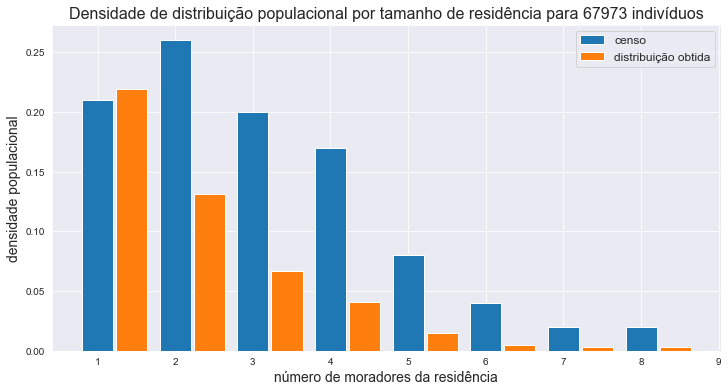

In [11]:
plt.figure(figsize=(12,6))
bar_width = 0.4
r1 = [j for j in range(1,num_tam_res+1)]
r2 = [j + 1.1*bar_width for j in range(1,num_tam_res+1)]
plt.bar(r1, censo_residencial, width=bar_width, label='censo')
plt.bar(r2, distrib_res/num_pop, width=bar_width, label=f'distribuição obtida')
plt.xlabel('número de moradores da residência', fontsize=14)
plt.ylabel('densidade populacional', fontsize=14)
plt.legend(fontsize=12)
plt.title(f'Densidade de distribuição populacional por tamanho de residência para {num_pop} indivíduos',
          fontsize=16)
plt.show()  

## Pirâmide etária do rio de Janeiro

- Como as pirâmides etárias do Rio de Janeiro e do Brasil são razoavelmente diferentes, vamos trabalhar com os dados do Rio.

- Inicialmente, consideramos a pirâmide populacional da cidade do Rio de Janeiro disponível na [Tabela 6407 do IBGE - População residente, por sexo e grupo de idade](https://sidra.ibge.gov.br/tabela/6407#resultado), que infelizemente não diferencia faixas acima de 65 anos:


| Total | 100,0 |
| --- | --- |
| 0 a 4 anos | 9,4 |
| 5 a 9 anos | 11,9 |
| 10 a 13 anos | 13,2 |
| 14 a 17 anos | 15,5 |
| 18 e 19 anos | 14,2 |
| 20 a 24 anos | 14,0 |
| 25 a 29 | 22,0 |
| 30 a 39 anos | 15,5 |
| 40 a 49 anos | 14,2 |
| 50 a 59 anos | 14,0 |
| 60 a 64 anos | 14,0 |
| 65 ou mais | 22,0 |



###  Tabelando os dados disponíveis

Primeiramente montamos duas listas, umas com as faixas etárias e outra com a fração da população em cada faixa.

In [12]:
idades_grupos = np.array([0, 5, 10, 14, 18, 20, 25, 30, 40, 50, 60, 65, 100])
idades_fracoes_grupos = np.array([0.047, 0.046, 0.043, 0.049, 0.027, 0.065, 0.067, 0.155, 0.142,
                                  0.140, 0.064, 0.155])
print(f'Conferindo a soma das frações dos grupos de idades: {idades_fracoes_grupos.sum()}')

Conferindo a soma das frações dos grupos de idades: 1.0


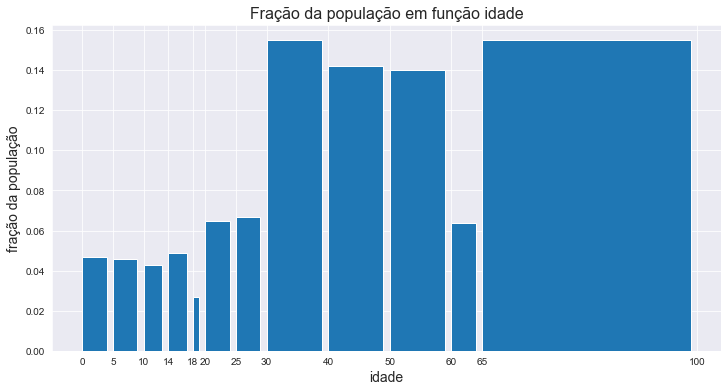

In [13]:
plt.figure(figsize=(12,6))
bar_width = [idades_grupos[j+1] - idades_grupos[j] - 1 for j in range(len(idades_grupos)-1)]
plt.bar(idades_grupos[:-1], idades_fracoes_grupos, width=bar_width, align='edge')
plt.xticks(idades_grupos)
plt.xlabel('idade', fontsize=14)
plt.ylabel('fração da população', fontsize=14)
plt.title('Fração da população em função idade', fontsize=16)
plt.show()

### Interpolando e extrapolando os dados

Agora, interpolamos os dados para ter frações para cada idade na faixas acima e extrapolamos no caso da última faixa.

Vou fazer uma interpolação/extrapolação simples, de maneira constante por partes, mas podemos melhorar isso, principalmente usando o número de nascidos na faixa de 0 a 1 ano e frações para idades maiores.

In [14]:
idade = 0
idades_fracoes = list()
for j in range(len(idades_grupos)-1):
    idades_fracoes += (idades_grupos[j+1] - idades_grupos[j]) \
        * [idades_fracoes_grupos[j]/(idades_grupos[j+1]-idades_grupos[j])]

idades_fracoes = np.array(idades_fracoes)
print(idades_fracoes.sum())

1.0000000000000002


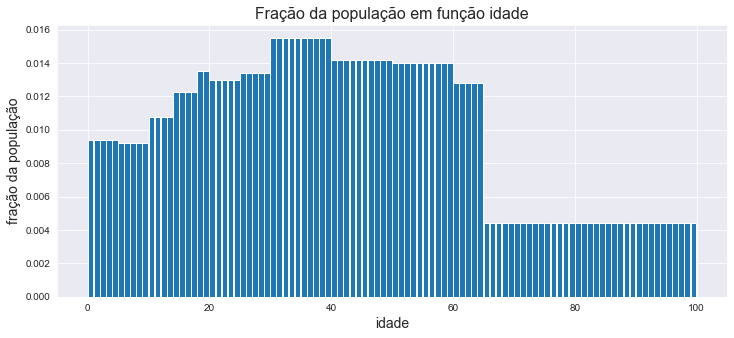

In [15]:
plt.figure(figsize=(12,5))
plt.bar(range(len(idades_fracoes)), idades_fracoes, width=0.95, align='edge')
plt.xlabel('idade', fontsize=14)
plt.ylabel('fração da população', fontsize=14)
plt.title('Fração da população em função idade', fontsize=16)
plt.show()

## Distribuição das idades dos indivíduos

- A estratégia é usar os dados da pirâmide populacional do Rio de Janeiro como pesos nas escolhas das idades dos indivíduos.

- Vamos fazer por partes, percorrendo as residências por tamanho e sorteando as idades dos residentes;

    - Nas casas com um único indivíduo, sorteamos um adulto (20 anos para cima), com pesos proporcionais as faixas de 20 pra cima.
    
    - Nas casas com dois indivíduos, sorteamos 90% deles com dois adultos e 10% deles com um adulto e uma criança
    
    - Nas casas com mais de dois indivíduos, sorteamos dois adultos e o restante de qualquer idade
    
    - A cada passo, atualizamos a população restante para obter novos pesos.

### Distribuindo as idades

- Primeiro, consideramos a população em idade ativa.

- De acordo com o IBGE, a população em idade ativa é formada pelos indivíduos com 16 ou mais anos de idade.

- Segundo, consideramos a parte economicamente ativa, que são os, de fato, trabalhando de alguma forma. Nesse caso:

    - Boa parte dos que têm até 17 ou 18 anos ainda está no ensino médio.

    - Uma certa parte dos que têm em torno de vinte anos está na faculdade.
    
    - Boa parte dos que têm 60 anos ou mais está aposentada.
    
    - Uma parte razoável dos outros está desocupada.
    

- Na falta de dados concretos, vou assumir certas frações das populações dessas idades como estando economicamente ativas, para serem alocadas nos locais de trabalho.

### Separa as residências por tamanho

In [16]:
%%time
res_indices = range(len(res_individuos))
res_1 = [r for r in res_individuos if len(r) == 1]
res_2 = [r for r in res_individuos if len(r) == 2]
res_2b = random.sample(res_2, k=int(0.1*len(res_2)))
res_2a = [r for r in res_2 if r not in res_2b]
res_3 = [r for r in res_individuos if len(r) >= 3]

CPU times: user 387 ms, sys: 2.44 ms, total: 390 ms
Wall time: 390 ms


### Separa a piramide populacional em crianças/jovens e adultos

As distribuições são apenas para definir os pesos para as escolhas das idades, não sendo estritamente necessário transformá-los em inteiros cuja soma dê exatamente a população total.

In [17]:
idades = list(range(len(idades_fracoes)))

distrib_idades_adultos = num_pop*idades_fracoes
distrib_idades_adultos[:20] = 0

distrib_idades_menores = num_pop*idades_fracoes
distrib_idades_menores[20:] = 0

In [18]:
print(distrib_idades_adultos.sum() + distrib_idades_menores.sum())
print(num_pop)

67972.99999999999
67973


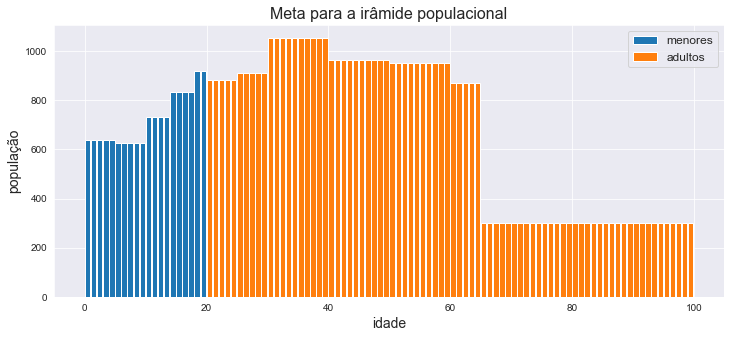

In [19]:
plt.figure(figsize=(12,5))
#plt.bar(range(len(idades_fracoes)), num_pop*idades_fracoes, width=0.95, align='edge')
#plt.plot(range(len(idades_fracoes)),num_pop*idades_fracoes, 'r')
plt.bar(range(len(distrib_idades_menores)), distrib_idades_menores, width=0.9, align='edge', label='menores')
plt.bar(range(len(distrib_idades_adultos)), distrib_idades_adultos, width=0.9, align='edge', label='adultos')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title('Meta para a irâmide populacional', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### Inicializa a lista de idades dos indivíduos

In [20]:
pop_idades = np.zeros(num_pop).astype(int)
n = 0

### Define a idade dos adultos morando sozinhos

Colocamos um adulto nas residências que contém apenas um indivíduo.

In [21]:
%%time
random.seed(17000000)

ind_idades = random.choices(idades, distrib_idades_adultos, k=len(res_1))
for j in range(len(res_1)):
    pop_idades[res_1[j]] = ind_idades[j]
    distrib_idades_adultos[ind_idades[j]] -= 1
n += len(res_1)    
print(n)

14872
CPU times: user 62.4 ms, sys: 1.84 ms, total: 64.3 ms
Wall time: 63.9 ms


In [22]:
%%time

#for r in res_1:
#    ind_idade = random.choices(idades, distrib_idades_adultos, k=1)[0]
#    pop_idades[r[0]] = ind_idade
#    distrib_idades_adultos[ind_idade] -= 1
#    n += 1

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


### Define a idade do único adulto em residências com um adulto e um menor

In [23]:
%%time
random.seed(27000000)

ind_idades = random.choices(idades, distrib_idades_adultos, k=len(res_2b))
for j in range(len(res_2b)):
    pop_idades[res_2b[j]] = ind_idades[j]
    distrib_idades_adultos[ind_idades[j]] -= 1
n += len(res_2b)
print(n)

15766
CPU times: user 5.14 ms, sys: 144 µs, total: 5.28 ms
Wall time: 5.34 ms


In [24]:
%%time
#random.seed(27000000)
#for r in res_2b:
#    ind_idade = random.choices(idades, distrib_idades_adultos, k=1)[0]
#    pop_idades[r[0]] = ind_idade
#    distrib_idades_adultos[ind_idade] -= 1
#    n += 1

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 13.1 µs


### Define a idade de dois adultos nas outras residências com dois indivíduos

- Nas residêcias com apenas dois indivíduos, já colocamos, anteriormente, um adulto nas residências com uma adulto e um menor. Agora, colocamos dois adultos no restante das residências com dois indivíduos.

In [25]:
%%time
len_res_2a = len(res_2a)
ind_idades = random.choices(idades, distrib_idades_adultos, k=2*len_res_2a)
for j in range(len_res_2a):
    pop_idades[res_2a[j][0]] = ind_idades[j]
    pop_idades[res_2a[j][1]] = ind_idades[len_res_2a + j]
    distrib_idades_adultos[ind_idades[j]] -= 1
    distrib_idades_adultos[ind_idades[len_res_2a + j]] -= 1
n += 2*len_res_2a
print(f'Alocados até o momento: {n}')

Alocados até o momento: 31866
CPU times: user 43.5 ms, sys: 2.07 ms, total: 45.6 ms
Wall time: 46.9 ms


### Define a idade de dois adultos nas residências com três ou mais indivíduos

In [26]:
%%time
len_res_3 = len(res_3)
ind_idades = random.choices(idades, distrib_idades_adultos, k=2*len_res_3)
for j in range(len_res_3):
    pop_idades[res_3[j][0]] = ind_idades[j]
    pop_idades[res_3[j][1]] = ind_idades[len_res_3 + j]
    distrib_idades_adultos[ind_idades[j]] -= 1
    distrib_idades_adultos[ind_idades[len_res_3 + j]] -= 1
n += 2*len_res_3
print(f'Alocados até o momento: {n}')

Alocados até o momento: 50088
CPU times: user 46.6 ms, sys: 2.16 ms, total: 48.8 ms
Wall time: 48.6 ms


### Define a idade dos menores de idade em residências com um adulto e um menor

In [27]:
%%time
len_res_2b = len(res_2b)
ind_idades = random.choices(idades, distrib_idades_menores, k=len_res_2b)
for j in range(len_res_2b):
    pop_idades[res_2b[j][1]] = ind_idades[j]
    distrib_idades_menores[ind_idades[j]] -= 1
n += len_res_2b
print(f'Alocados até o momento: {n}')

Alocados até o momento: 50982
CPU times: user 3.33 ms, sys: 608 µs, total: 3.94 ms
Wall time: 3.47 ms


### Calcula a distribuição restante de idades

In [28]:
distrib_idades_left = np.array([distrib_idades_menores[j] + distrib_idades_adultos[j] for j in range(len(idades_fracoes))])
print(distrib_idades_left.astype(int))

[598 599 600 606 594 588 585 589 581 581 690 695 683 679 787 771 772 776
 873 856  79  60  65  82  48  75  39  78  52  50  79  84  77  68  59  90
  44  14  61  55  50  54  67  50  76  51  60  74  47  73  62  39  57  62
  61  71  89  67  68  47  56  59  69  43  56   4  38  19   4  21  29  14
   9  15  23  34   0  39   6  14  27   6  21  15  30  11  38  15  28  30
  15  17  22  26  19  10  19  17  25  25]


### Define a idade do restante dos invidívuos em residências de três ou mais indivíduos

In [29]:
%%time
for r in res_3:
    ind_idade = random.choices(idades, distrib_idades_left, k=len(r)-2)
    pop_idades[r[2:]] = ind_idade
    for j in ind_idade:
        distrib_idades_left[j] -= 1
        n += 1
print(f'Alocados ao final: {n}')

Alocados ao final: 67973
CPU times: user 327 ms, sys: 3.13 ms, total: 330 ms
Wall time: 334 ms


### Conferindo

In [30]:
print(f'População total: {num_pop}')
print(f'Alocados ao final: {n}')
pop_idades_hist = np.array([len(pop_idades[pop_idades==j]) for j in range(100)])
print(f'Total de alocados via somatório do histograma: {pop_idades_hist.sum()}')
print(f'Distribuição de indivíduos em função da idade:\n{pop_idades_hist}')

População total: 67973
Alocados ao final: 67973
Total de alocados via somatório do histograma: 67973
Distribuição de indivíduos em função da idade:
[ 639  639  640  638  639  625  626  624  626  626  730  731  733  731
  832  833  832  833  917  917  884  884  884  884  883  911  910  911
  911  911 1054 1053 1054 1053 1054 1054 1052 1054 1054 1053  966  965
  964  966  965  966  965  966  964  966  951  952  952  952  952  950
  952  952  951  952  870  870  870  870  870  301  302  301  301  301
  301  301  301  301  301  300  301  301  301  301  301  302  300  301
  302  301  301  301  301  301  300  301  301  301  301  301  301  301
  301  301]


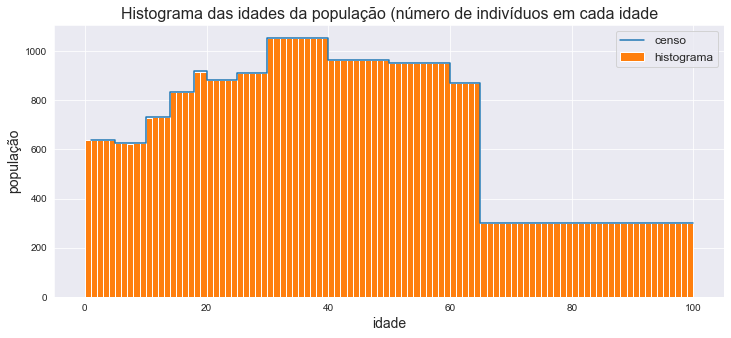

In [31]:
plt.figure(figsize=(12,5))
plt.hist(pop_idades, bins = list(range(101)), color='tab:orange', label='histograma')
plt.step([i+1 for i in idades],num_pop*idades_fracoes, label='censo')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title('Histograma das idades da população (número de indivíduos em cada idade', fontsize=16)
plt.legend(fontsize=12)
plt.show()

<!--NAVIGATOR-->

---
[<- Modelos individuais - reformulação da implementação](16.00.Aula-Modelos_individuais_reformulacao.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [O cenário de múltiplos do Pop350: redes sociais ->](18.00.Aula-Construindo_Cenarios_e_Pop_Multi_350_social.ipynb)